# Landslide Susceptibility Calculation for Tuscany, Italy

<a id='setup'></a>
## Initial Setup

We will need to install several python packages and create folders for this notebook. After you install the packages, you will need to run a helper function to create API Key files for the Topography and ERA5 data components.

### Install Packages (on Local PC)
If you want to run this notebook on your PC, you can run the following command which will create a separate conda environment named "landslide_usecase" and install all the required packages for you. After the installation, please make sure to activate the environment to run this notebook.

In [ ]:
# ! conda env create --file=environment.yml

### Install API key files
For the ERA5 and Topography data components, there is a need to create API key files to download the datasets. The install_api_key( ) function will ask for your [CDS API Key](https://cds.climate.copernicus.eu/api-how-to) and [Open Topography API Key](https://opentopography.org/blog/introducing-api-keys-access-opentopography-global-datasets) to create API key files. Please make sure you have already obtained those API Keys before you run this helper function. 


In [1]:
from utils import install_api_key
install_api_key()

Enter Your OpenTopography API Key:  5322d930983feef27e44494650831295


OpenTopography API Key file is created at /home/jupyter-sarah.g.williams@v-81814/landslide_espin_2023/landslide_espin_2023/Landslide_Italy/.opentopography.txt.


Enter Your CDS API Key:  196789:837fd780-3ffa-4deb-be16-e65d46d630fe


CDS API Key file is created at /home/jupyter-sarah.g.williams@v-81814/.cdsapirc


### Create folders
We will first import all the python packages and then create three folders for this notebook:
- **configuration file folder**: this folder includes several configuration files which will be used by the data components. In this example, we have prepared these configuration files ('dem_config.yaml' and 'era5_config.yaml') and put them in this folder. 
- **cache folder**: this folder stores the downloaded data files.
- **results folder**: this folder stores the final results.

In [2]:
# import packages 
import os
import warnings

import numpy as np
import pandas as pd
import xarray
import xesmf as xe
import rioxarray 
import cftime
from datetime import datetime
from tqdm import trange
import matplotlib.pyplot as plt
from matplotlib import colors
import imageio.v2 as imageio
from IPython.display import Video

from landlab import RasterModelGrid
from pymt.models import Topography, Era5

from utils import regrid_data, cal_subsurface_flow_depth, cal_safety_factor

warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams.update({'font.size': 14})

In [3]:
# create folders
study_area = 'italy'

config_dir = os.path.join(os.getcwd(), 'config_files_{}'.format(study_area))
results_dir = os.path.join(os.getcwd(), 'results_{}'.format(study_area)) 
cache_dir = os.path.join(os.getcwd(),'cache_{}'.format(study_area))


for folder in [config_dir, results_dir, cache_dir]:
    if not os.path.isdir(folder):
        os.mkdir(folder)
        print(folder)

<a id='step1'></a>
## Step 1 Download Datasets

### Background 

Landslides are frequent hazards in Puerto Rico which are mainly caused by the steep terrain and heavy rainfall from hurricanes and other tropical weather systems. For example, Hurricane Maria hit the island of Puerto Rico on September 20th, 2017 and triggered more than 40,000 landslides in Puerto Rico (see details [here](https://www.usgs.gov/supplemental-appropriations-for-disaster-recovery-activities/landslides-triggered-hurricane-maria)). The map below shows concentration and distribution of landslides generated by rainfall associated with Hurricane Maria in Puerto Rico (map source from [USGS](https://www.usgs.gov/supplemental-appropriations-for-disaster-recovery-activities/assessment-landslide-and-debris-flow)).

In this example, we will calculate the hourly landslide susceptibility for the area that has high concentration of landslide of Puerto Rico during Hurricane Maria. We will prepare the following datasets to calculate the landslide susceptibility. Details for how to calculate the landslide susceptibility is described in [Step 3](#step3)
- OpenTopography DEM 
- ERA5 volumetric soil water and precipitation 
- Soil depth  
- Slope angle

<img src="map_italy.png" height='800' width="600">
<!-- <img src="https://github.com/gantian127/landslide_usecase/blob/master/Landslide_map.jpeg?raw=true" width="900"> -->

### OpenTopography DEM 

We will use the [Topography data component](https://csdms.colorado.edu/wiki/Model:Topography_Data_Component) to download the Digital Elevation Model (DEM) data with 90m resolution. The figure below shows the bounding box of the study area. The 'dem_config.yaml' file includes the parameter settings of this data component. The following cells demonstrate how to use the configuration file to initialize a data component and how to use the variable and grid related methods of this data component to get the metadata as well as the data values.

<img src="Tuscany_Study.png" height='800' width="600">
<!-- <img src="https://github.com/gantian127/landslide_usecase/blob/master/study_area.png?raw=true" width="850"> -->

Image Source: Rosi, A., Tofani, V., Tanteri, L. et al. The new landslide inventory of Tuscany (Italy) updated with PS-InSAR: geomorphological features and landslide distribution. Landslides 15, 5–19 (2018). https://doi.org/10.1007/s10346-017-0861-4

In [4]:
# initialize Topography data component
dem = Topography()
dem.initialize(os.path.join(config_dir, 'dem_config.yaml'))

In [5]:
# get DEM variable info
var_name = dem.output_var_names[0]
var_unit = dem.var_units(var_name)
var_location = dem.var_location(var_name)
var_type = dem.var_type(var_name)
var_grid = dem.var_grid(var_name)
var_itemsize = dem.var_itemsize(var_name)
var_nbytes = dem.var_nbytes(var_name)
print('variable_name: {} \nvar_unit: {} \nvar_location: {} \nvar_type: {} \nvar_grid: {} \nvar_itemsize: {}' 
            '\nvar_nbytes: {} \n'. format(var_name, var_unit, var_location, var_type, var_grid, var_itemsize, var_nbytes))

variable_name: land_surface__elevation 
var_unit: degrees 
var_location: face 
var_type: int16 
var_grid: 0 
var_itemsize: 2
var_nbytes: 460800 



In [6]:
# get DEM grid info 
dem_grid_ndim = dem.grid_ndim(var_grid) 
dem_grid_type = dem.grid_type(var_grid)
dem_grid_shape = dem.grid_shape(var_grid)
dem_grid_spacing = dem.grid_spacing(var_grid)
dem_grid_origin = dem.grid_origin(var_grid)

print('grid_ndim: {} \ngrid_type: {} \ngrid_shape: {} \ngrid_spacing: {} \ngrid_origin: {}'.format(
    dem_grid_ndim, dem_grid_type, dem_grid_shape, dem_grid_spacing, dem_grid_origin))

grid_ndim: 2 
grid_type: uniform_rectilinear 
grid_shape: [480 480] 
grid_spacing: [ 0.00083333  0.00083333] 
grid_origin: [ 43.85083333  10.5       ]


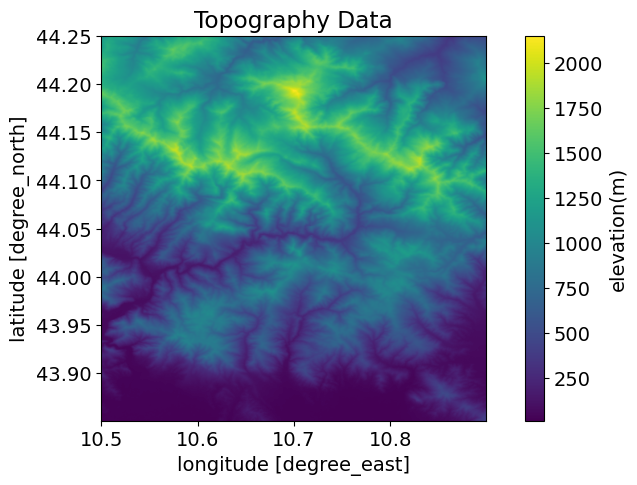

In [7]:
# get DEM variable data
dem_data = dem.get_value(var_name)
dem_data_2D = dem_data.reshape(dem_grid_shape)

# get X, Y extent for plot
min_y, min_x = dem_grid_origin
max_y = min_y + dem_grid_spacing[0]*(dem_grid_shape[0]-1)
max_x = min_x + dem_grid_spacing[1]*(dem_grid_shape[1]-1)
dy = dem_grid_spacing[0]/2
dx = dem_grid_spacing[1]/2
dem_extent = [min_x - dx, max_x + dx, min_y - dy, max_y + dy]

# plot DEM data
fig, ax = plt.subplots(1,1,figsize=(10,5))
im = ax.imshow(dem_data_2D, extent=dem_extent)
ax.title.set_text('Topography Data')
ax.set_xlabel('longitude [degree_east]')
ax.set_ylabel('latitude [degree_north]')
fig.colorbar(im,label='elevation(m)')

### ERA5 Volumetric Soil Water & Precipitation 
We will use the [ERA5 data component](https://csdms.colorado.edu/wiki/Model:ERA5_Data_Component) to download the hourly volumetric soil water data and the precipitation data of the study area with 0.25 degrees (27-28km) resolution. The volumetric soil water data will be used for calculating the susceptibility, while the precipitation data is mainly used for results visualization. 

The 'era5_config.yaml' file includes the parameter settings of this data component. The following cells demonstrate how to use the configuration file to initialize an ERA5 data component and how to use the variable, grid and time related methods to get the metadata as well as the data values. You'll notice that although the ERA5 and Topography data components download the datasets from different sources, they are using the same methods to get information from the datasets. Please note that sometimes the request for ERA5 data may be queued which may take a while (>10min) to get the data downloaded.

In [8]:
# initialize ERA5 data component
era5 = Era5()
era5.initialize(os.path.join(config_dir,'era5_config.yaml'))

In [8]:
# # get ERA5 variable info
# for var_name in era5.output_var_names:
#     var_unit = era5.var_units(var_name)
#     var_location = era5.var_location(var_name)
#     var_type = era5.var_type(var_name)
#     var_grid = era5.var_grid(var_name)
#     var_itemsize = era5.var_itemsize(var_name)
#     var_nbytes = era5.var_nbytes(var_name)
#     print('variable_name: {} \nvar_unit: {} \nvar_location: {} \nvar_type: {} \nvar_grid: {} \nvar_itemsize: {}' 
#             '\nvar_nbytes: {} \n'. format(var_name, var_unit, var_location, var_type, var_grid, var_itemsize, var_nbytes))

variable_name: Total precipitation 
var_unit: m 
var_location: node 
var_type: float64 
var_grid: 0 
var_itemsize: 2
var_nbytes: 98 

variable_name: Volumetric soil water layer 1 
var_unit: m**3 m**-3 
var_location: node 
var_type: float64 
var_grid: 0 
var_itemsize: 2
var_nbytes: 98 

variable_name: Volumetric soil water layer 2 
var_unit: m**3 m**-3 
var_location: node 
var_type: float64 
var_grid: 0 
var_itemsize: 2
var_nbytes: 98 

variable_name: Volumetric soil water layer 3 
var_unit: m**3 m**-3 
var_location: node 
var_type: float64 
var_grid: 0 
var_itemsize: 2
var_nbytes: 98 

variable_name: Volumetric soil water layer 4 
var_unit: m**3 m**-3 
var_location: node 
var_type: float64 
var_grid: 0 
var_itemsize: 2
var_nbytes: 98 



In [9]:
# # get ERA5 grid info
# era5_grid_ndim = era5.grid_ndim(var_grid) 
# era5_grid_type = era5.grid_type(var_grid)
# era5_grid_shape = era5.grid_shape(var_grid)
# era5_grid_spacing = era5.grid_spacing(var_grid)
# era5_grid_origin = era5.grid_origin(var_grid)

# print('grid_ndim: {} \ngrid_type: {} \ngrid_shape: {} \ngrid_spacing: {} \ngrid_origin: {}'.format(
#     era5_grid_ndim, era5_grid_type, era5_grid_shape, era5_grid_spacing, era5_grid_origin))

grid_ndim: 2 
grid_type: uniform_rectilinear 
grid_shape: [7 7] 
grid_spacing: [ 0.25  0.25] 
grid_origin: [ 43.   10.5]


In [10]:
# # get ERA5 time info
# era5_start_time = era5.start_time
# era5_end_time = era5.end_time
# era5_time_step = era5.time_step
# era5_time_unit = era5.time_units
# era5_time_steps = int((era5_end_time - era5_start_time)/era5_time_step) + 1

# print('start_time:{} \nend_time:{} \ntime_step:{} \ntime_unit:{} \ntime_steps:{}'.format(
#     era5_start_time, era5_end_time, era5_time_step, era5_time_unit, era5_time_steps))

start_time:1031904.0 
end_time:1031999.0 
time_step:1.0 
time_unit:hours since 1900-01-01 00:00:00.0 
time_steps:96


### Soil Depth data

Since the data component for soil depth data is not available yet, we will use the xarray and rioxarray to subset and download the soil depth data with 250m resolution from [SoilGrids](https://www.isric.org/explore/soilgrids) system. In this dataset, the maximum soil depth value is 200cm. Grid with values larger than 200cm represents open water area. 

In [9]:
# download soil depth data
soil_raster = rioxarray.open_rasterio("https://files.isric.org/soilgrids/former/2017-03-10/data/BDRICM_M_250m_ll.tif")
soil_depth_data = soil_raster.rio.clip_box(
    minx=10.50,
    miny=43.50,
    maxx=11.25,
    maxy=44.25,
)

Text(0.5, 1.0, 'Soil Depth')

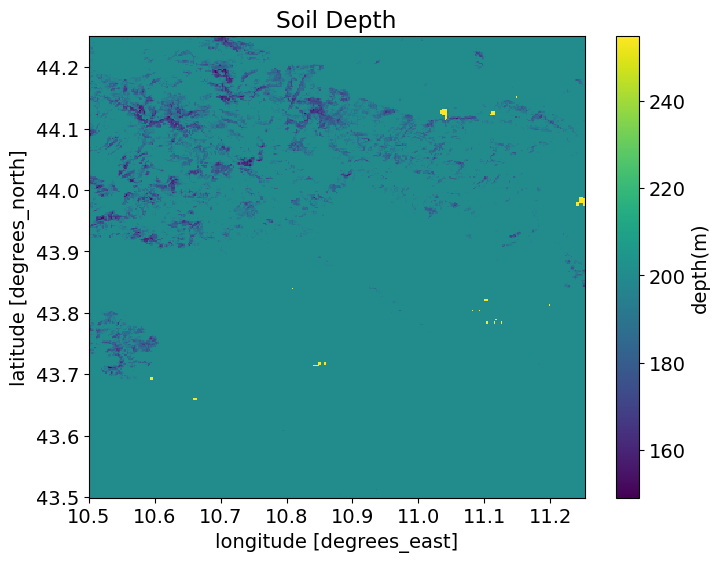

In [10]:
# plot soil depth data
soil_depth_data.plot(figsize=(8,6),cbar_kwargs={'label': 'depth(m)'})
soil_depth_data.rio.to_raster(os.path.join(cache_dir,'soil_depth.tif'))
plt.title('Soil Depth')

### Slope angle

Slope angle is one of the input for calculating the landslide susceptibility. In this example, we will use the Topography data and the [RasterModelGrid](https://landlab.readthedocs.io/en/master/reference/grid/raster.html) from [Landlab](https://landlab.readthedocs.io/en/master/index.html) to calculate the slope angle for the study area. 

In [11]:
# calculate slope angle using Topography data
model_grid = RasterModelGrid(dem_data_2D.shape,xy_spacing=(90,90))
slope = model_grid.calc_slope_at_node(elevs=dem_data) # slope in radians, 1D array
slope_angle = slope.reshape(dem_data_2D.shape) # reshape as 2D array

Text(0, 0.5, 'latitude [degree_north]')

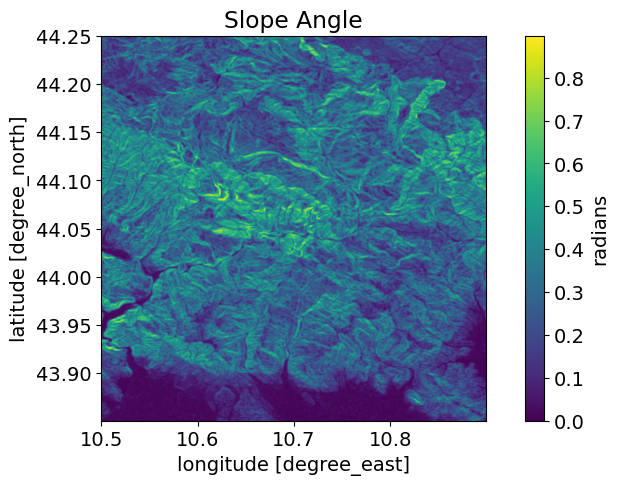

In [12]:
# plot slope angle
fig, ax = plt.subplots(figsize=(10,5))
im=ax.imshow(slope_angle, extent=dem_extent)
cbar = fig.colorbar(im, label= 'radians')
ax.title.set_text('Slope Angle')
ax.set_xlabel('longitude [degree_east]')
ax.set_ylabel('latitude [degree_north]')

<a id='step2'></a>
## Step 2 Regrid datasets

Before calculating the landslide susceptibility, we need to regrid all the datasets in the same grid resolution. We will take the Topography dataset as the template to regrid the soil depth and the ERA5 datasets. This will make these datasets to have the same resolution as the Topography dataset. Since all the original datasets are in the WGS84 geographic coordinate system, there is no need for data reprojection. Because ERA5 datasets are multidimensional space time data, we will regrid ERA5 datasets in a for loop in [Step3](#step3). In this example, we will use the regrid_data( ) function for regridding purpose. 



In [13]:
# define destination grid coordinate using Topography data
dem_y = np.flip(np.arange(dem_grid_shape[0])*dem_grid_spacing[0] + dem_grid_origin[0])
dem_x = np.arange(dem_grid_shape[1])*dem_grid_spacing[1] + dem_grid_origin[1]
dest_coor = {'lon': dem_x, 
             'lat': dem_y}

In [14]:
# regrid soil depth data
soil_depth_coor = {'lon': soil_depth_data.x.values,
                   'lat': soil_depth_data.y.values}

soil_depth = regrid_data(soil_depth_data.values[0], soil_depth_coor, dest_coor) 
soil_depth = soil_depth/100 # units conversion as m

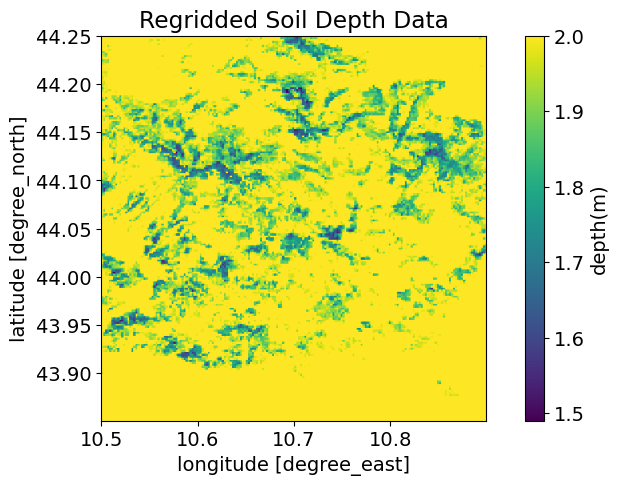

In [15]:
# plot regridded soil depth data
fig, ax = plt.subplots(1,1,figsize=(10,5))
im = ax.imshow(soil_depth, extent=dem_extent)
ax.title.set_text('Regridded Soil Depth Data')
ax.set_xlabel('longitude [degree_east]')
ax.set_ylabel('latitude [degree_north]')
cbar = plt.colorbar(im, label='depth(m)')

<a id='step3'></a>
## Step 3  Calculate Susceptibility

This section will loop through each time step to calculate the hourly landslide susceptibility, which mainly includes the following tasks:
- Regrid ERA5 datasets
- Calculate subsurface flow depth
- Calculate factor of safety
- Calculate susceptibility
- Plot results


**Regrid ERA5 datasets**

The ERA5 precipitation and volumetric soil water datasets will be regridded in a higher resolution by using the Topography dataset as the template. The regrid_data( ) function will be used which is similar as the code shown in [Step2](#step2). As mentioned before, the volumetric soil water data is used for calculation and the precipitation data is mainly used to visualize the rainfall change during the time period. 

**Subsurface flow depth** 

The subsurface flow depth is calculated using the soil depth data and the ERA5 volumetric soil water datasets. There are four layers of the ERA5 volumetric soil water data (Layer 1: 0 - 7cm, Layer 2: 7 - 28cm, Layer 3: 28 - 100cm, Layer 4: 100 - 289cm). We first calculate the product of the soil depth at each layer and its corresponding volumetric soil water data. Then this product is divided by the porosity, which represents the water depth at each soil layer. Then we add up the water depth values of all four layers, which will be an approximation of the subsurface flow depth. The cal_subsurface_flow_depth( ) function is used for calculation.

**Factor of safety**

In geological engineering, it is common to take the ratio of the resisting stresses to driving stresses. This ratio is called the factor of safety (FS). When FS is larger than 1, the slope should be stable, while if it is below 1, the driving stress exceeds the resistance and the slope is likely to fail. FS can be calculated with the following function, and cal_safety_factor( ) is implemented based on this function.

$$
FS = \frac{(C_r + C_s)/h_s\rho_sg}{\sin\theta} + \frac{\cos\theta \tan\phi (1-\frac{h_w}{h_s}\rho_w / \rho_s)}{\sin\theta}
$$

where, 
- Cr: root cohesion (Pa kg/ms^2)
- Cs: soil cohesion (Pa kg/ms^2)
- hs: soil depth (m)
- hw: subsurface flow depth (m)
- ρs: soil density (kg/m^3)
- ρw: water density (kg/m^3)
- g: gravity acceleration (m/s^2)
- θ: slope angle 
- φ: soil internal friction angle 

**Susceptibility**

Susceptibility is the inverse of FS. When the susceptibility is larger than 1, it means that the slope of the area is not stable and susceptible to landslide.  

$$
\text{Susceptibility} = \frac{1}{FS}
$$


**Plot Results**

There are four subplots created at each time step. The top left plot shows the landslide susceptibility at first time step and then it shows the difference of the landslide susceptibility between the current and the first time step. Similarly, the lower left plot shows the subsurface flow depth at the first time step and then the difference of the subsurface flow depth. The two plots on the right show the time series of mean total precipitation and the mean volumetric soil water content for the study area respectively. Please note that these two plots are not shown at the first time step.

In [16]:
# Specify minimum and maximum root cohesion parameters for the area
min_Cr=3000
max_Cr=12000

# Do a list with 4 equally spaced values within that range 
step_Cr=int(((max_Cr+min_Cr)-min_Cr)/4)
root_c=[i for i in range(min_Cr,max_Cr+1,step_Cr)] #list of values for root cohesion repoorted for area

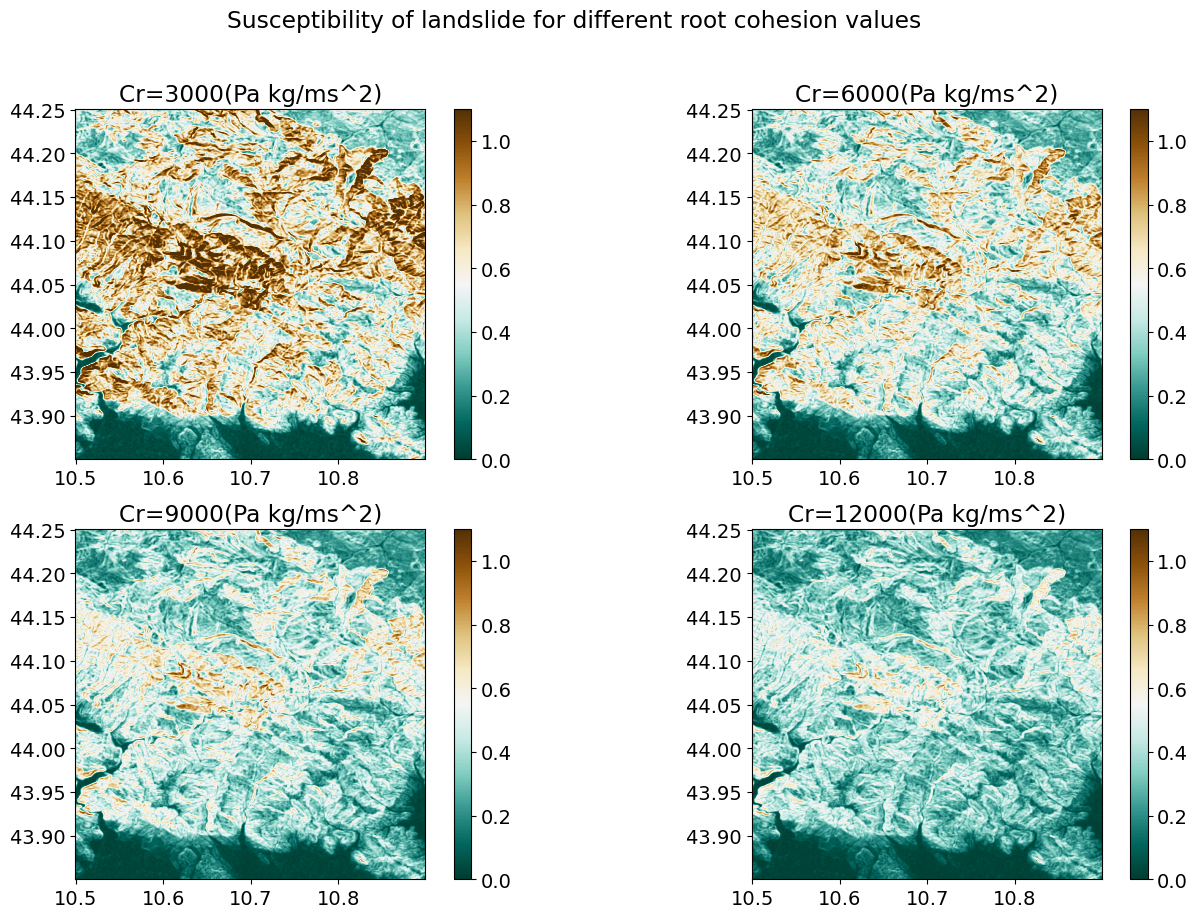

In [17]:
# define mask for non-data area (water bodies, etc)
mask = (slope_angle==0)&(soil_depth>2.0)

# we assume constant saturation so that relative wetness is one
subsurface_flow_depth = soil_depth 

# plot susceptibility 
fig = plt.figure(figsize=(16,10))
fig.suptitle("Susceptibility of landslide for different root cohesion values")

#change plot grid size if you want to explore more parameters in the above list
nrows, ncols = 2,2
    
# calculate FS for each root cohesion value
for i,cr in enumerate(root_c):
    safety_factor = cal_safety_factor(slope_angle, subsurface_flow_depth, soil_depth, 
                                  root_cohesion=cr, soil_cohesion=5000, soil_bulk_density=1300,
                                  soil_internal_friction_angle=35)
    
    # calculate susceptibility
    susceptibility = 1.0 / safety_factor
    susceptibility = np.where(~mask, susceptibility, np.nan) #water bodies
    
    # plot 
    ax = fig.add_subplot(nrows, ncols, i+1)
    ax.title.set_text('Cr='+str(cr)+"(Pa kg/ms^2)")
    im_data = susceptibility
    
###### Comment the 2 above lines and uncomment below to check the differences""   
#     if cr == 5000: 
#         ax = fig.add_subplot(nrows, ncols, 1)
#         im_data = susceptibility
#         reference_sus = np.copy(susceptibility) 
        
#     else: 
#         ax = fig.add_subplot(nrows, ncols, i+1)
#         im_data = susceptibility - reference_sus

    im_sus = ax.imshow(im_data, cmap='BrBG_r', extent=dem_extent)
    plt.colorbar(im_sus, ax=ax)
    im_sus.set_clim(0,1.1)
    

#save plot 
fig.savefig(results_dir+'/root_cohesion_plot.png')



<a id='step4'></a>
## Step 4 Vary Root Cohesion and Soil Saturation

... run same code again but this time include changing soil saturation along with root cohesion... CAN INTERNAL CALC BE MADE INTO A CLASS?

100%|██████████| 10/10 [00:11<00:00,  1.13s/it]


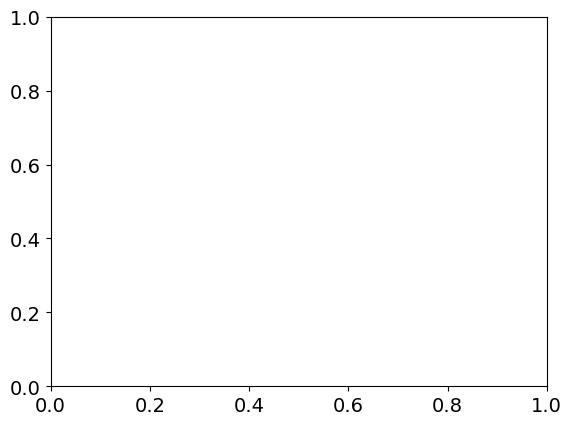

In [18]:
# Specify minimum and maximum root cohesion parameters for the area
min_Cr=3000
max_Cr=12000

# Do a list with 4 equally spaced values within that range 
step_Cr=int(((max_Cr+min_Cr)-min_Cr)/4)
root_c=[i for i in range(min_Cr,max_Cr+1,step_Cr)] #list of values for root cohesion repoorted for area

# set time steps for the loop
time_steps = 10 # for future run: 96 time steps covers the whole 4 days 

# define mask for non-data area (water bodies, etc)
mask = (slope_angle==0)&(soil_depth>2.0)

# plot susceptibility 
fig = plt.figure(figsize=(16,10))
fig.suptitle("Susceptibility of landslide for different soil saturations and root cohesion values")

#change plot grid size if you want to explore more parameters in the above list
nrows, ncols = 2,2
    
# calculate FS for each root cohesion value
for time_step in trange(0, time_steps): 
    for i,cr in enumerate(root_c):
        subsurface_flow_depth = time_step/10 * soil_depth
        safety_factor = cal_safety_factor(slope_angle, subsurface_flow_depth, soil_depth, 
                                      root_cohesion=cr, soil_cohesion=5000, soil_bulk_density=1300,
                                      soil_internal_friction_angle=35)

        # calculate susceptibility
        susceptibility = 1.0 / safety_factor
        susceptibility = np.where(~mask, susceptibility, np.nan) #water bodies

        # plot 
        ax = fig.add_subplot(nrows, ncols, i+1)
        ax.title.set_text('Cr='+str(cr)+"(Pa kg/ms^2)")
        im_data = susceptibility

    ###### Comment the 2 above lines and uncomment below to check the differences""   
    #     if cr == 5000: 
    #         ax = fig.add_subplot(nrows, ncols, 1)
    #         im_data = susceptibility
    #         reference_sus = np.copy(susceptibility) 

    #     else: 
    #         ax = fig.add_subplot(nrows, ncols, i+1)
    #         im_data = susceptibility - reference_sus

        im_sus = ax.imshow(im_data, cmap='BrBG_r', extent=dem_extent)
        plt.colorbar(im_sus, ax=ax)
        im_sus.set_clim(0,1.1)

    plt.close(fig)
    fig.savefig(os.path.join(results_dir, 'sus_root_{}.png'.format(time_step)))
    

Now all of our models have been run. Let's show them nicely together

In [43]:
## Want to visualize for saturation by column, root cohesion by row



## References
- Strauch, R., Istanbulluoglu, E., Nudurupati, S. S., Bandaragoda, C., Gasparini, N. M., and Tucker, G. E. (2018), A hydroclimatological approach to predicting regional landslide probability using Landlab, Earth Surf. Dynam., 6, 49–75, https://doi.org/10.5194/esurf-6-49-2018
- Montgomery, D. R., and Dietrich, W. E. (1994), A physically based model for the topographic control on shallow landsliding, Water Resour. Res., 30( 4), 1153– 1171, https://doi.org/10.1029/93WR02979.